# Applied Data Science 2 - Keras Assignment - 2023A

In this assignment you will be building a script to classify movie posters. The assignment is broken up into sections and you need to complete each section successively. The sections are:

1. Data Processing
2. Model Definition
3. Model Training
4. Model Evaluation

In addition to this coding exercise, you will also need to write a 1-2 page report analysing and critically evaluating you models results.

In [16]:
# Enter your module imports here, some modules are already provided

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import pandas as pd
from sklearn import model_selection
from tensorflow.keras import layers, Model
from tensorflow.keras import losses, optimizers
from tensorflow.keras.optimizers import Adam
from keras.metrics import Precision, Recall

In [ ]:
# CodeGrade Tag Init1
# Do not edit, remove, or copy this cell

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Processing



In [ ]:
# CodeGrade Tag Init2
# Do not edit, remove, or copy this cell

# This code will copy the images from your google drive into the colab file
# storage. Make sure the dataset is unzipped in your drive folder.
! mkdir /tmp/Multi_Label_dataset
! rsync -ah --info=progress2 /content/drive/MyDrive/Multi_Label_dataset/Images /tmp/Multi_Label_dataset/

        191.81M 100%  768.49kB/s    0:04:03 (xfr#7905, to-chk=0/7906)


In [17]:
# CodeGrade Tag DataProc
# Do not edit, remove, or copy this cell

# Load the csv with the sample IDs and genres
csv_loc = "/content/drive/MyDrive/Multi_Label_dataset/train.csv"
dataset = pd.read_csv("/content/drive/MyDrive/Multi_Label_dataset/train.csv")

# Split the dataset into training and testing
data_train, data_test = model_selection.train_test_split(dataset, test_size=0.2)

# Convert the labels to arrays
labels_train = np.array(data_train.drop(['Id', 'Genre'],axis=1)).astype('float32')
labels_test = np.array(data_test.drop(['Id', 'Genre'],axis=1)).astype('float32')

# List of the genre names
genres = np.array(data_train.drop(['Id', 'Genre'],axis=1).columns)

# Build the file locations for the images
img_loc = "/tmp/Multi_Label_dataset/Images"

img_locs_train = np.array([[img_loc + '/' + id + '.jpg' for id in data_train['Id']]])
img_locs_test = [[img_loc + '/' + id + '.jpg' for id in data_test['Id']]]


# This function is provided to read in the image files from the folder
def parse_image(filename, label):
  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  return image, label

# Create the initial datasets
train_list_ds = tf.data.Dataset.from_tensor_slices((img_locs_train[0], labels_train))
test_list_ds = tf.data.Dataset.from_tensor_slices((img_locs_test[0], labels_test))

**Create a function called "img_process" converts the images to float32 datatype and resizes them to 64x64 pixels.**

In [18]:
# CodeGrade Tag Ex1a
### Write a function called img_process, which takes in the image and label as
### inputs, converts the data type of the image to tf.float32, resizes the
### image to (64, 64), and finally returns the image and labels.

def img_process(image, label):
    image = tf.image.convert_image_dtype(image, 'float32')
    image = tf.image.resize(image, (64, 64))

    return image, label

**Using the tf.data API, load in the training and validation data. Be mindful of efficient data processing good practice to minimise the time it takes to load the data.**

In [19]:
# CodeGrade Tag Ex1b
### Use the parse_image and img_process functions to construct the training and
### validation datasets. You should utilise good practice in optimising the
### dataset loading. Use a batch size of 64. Use techniques like caching and
### prefetching to efficiently load the data.

# Training datasets
train_dataset = (train_list_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)\
                             .batch(64)\
                             .map(img_process, num_parallel_calls=tf.data.AUTOTUNE)\
                             .cache()\
                             .shuffle(buffer_size=1000)\
                             .prefetch(tf.data.AUTOTUNE)
                             )

# Validation datasets
test_dataset = (test_list_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)\
                           .batch(64)\
                           .map(img_process, num_parallel_calls=tf.data.AUTOTUNE)\
                           .cache()\
                           .shuffle(buffer_size=1000)\
                           .prefetch(tf.data.AUTOTUNE)
                           )

# Model Definition

**Using the Keras Functional API, create a convolutional neural network with the architecture show in the model summary below.**

**A few important points to consider:**

* Call the convolutional layers and the first dense layer should have ReLU activation functions. The output layer should have a Sigmoid activation function.
* Pay attention to the output shapes and the number of partmeters for each layer, as these give indications as to the correct settings for the number of filters, kernel size, stride length and padding.
* Use the layer names provided in the summary in your model.
* For the dropout layers, use a dropout rate of 0.2 after the convolutional layers and 0.5 after the dense layers.


```
# Model Summary

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 32, 32, 16)        448       
                                                                 
 Drop1 (Dropout)             (None, 32, 32, 16)        0         
                                                                 
 Conv1 (Conv2D)              (None, 32, 32, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 Drop2 (Dropout)             (None, 32, 32, 32)        0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 Conv4 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 Drop3 (Dropout)             (None, 16, 16, 64)        0         
                                                                 
 Pool2 (MaxPooling2D)        (None, 8, 8, 64)          0         
                                                                 
 Conv5 (Conv2D)              (None, 8, 8, 128)         73856     
                                                                 
 Conv6 (Conv2D)              (None, 8, 8, 128)         147584    
                                                                 
 Drop4 (Dropout)             (None, 8, 8, 128)         0         
                                                                 
 Pool3 (MaxPooling2D)        (None, 4, 4, 128)         0         
                                                                 
 Flat (Flatten)              (None, 2048)              0         
                                                                 
 FC1 (Dense)                 (None, 1024)              2098176   
                                                                 
 Drop5 (Dropout)             (None, 1024)              0         
                                                                 
 FC2 (Dense)                 (None, 1024)              1049600   
                                                                 
 Drop6 (Dropout)             (None, 1024)              0         
                                                                 
 Output (Dense)              (None, 25)                25625     
                                                                 
=================================================================
Total params: 3464601 (13.22 MB)
Trainable params: 3464601 (13.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


```



In [20]:
# CodeGrade Tag Ex2a
### Define the model using the Keras Functional API. Use the summary above as a
### guide for the model parameters. You will need to define the filters/units of
### the layers correctly, as well as the kernel size, stride length and padding
### of the convolutional layers.

# Input layer
input = layers.Input((64, 64, 3), dtype='float32', name='Input')

# Convolutional layers
conv0 = layers.Conv2D(16, (3, 3), activation='relu', strides=2,
                      padding='same', name='Conv0')(input)

drop1 = layers.Dropout(0.2, name='Drop1')(conv0)

conv1 = layers.Conv2D(32, (3, 3), activation='relu',
                      padding='same', name='Conv1')(drop1)

conv2 = layers.Conv2D(32, (3, 3), activation='relu',
                      padding='same', name='Conv2')(conv1)

drop2 = layers.Dropout(0.2, name='Drop2')(conv2)

pool1 = layers.MaxPooling2D((2, 2), name='Pool1')(drop2)

conv3 = layers.Conv2D(64, (3, 3), activation='relu',
                      padding='same', name='Conv3')(pool1)

conv4 = layers.Conv2D(64, (3, 3), activation='relu',
                      padding='same', name='Conv4')(conv3)

drop3 = layers.Dropout(0.2, name='Drop3')(conv4)

pool2 = layers.MaxPooling2D((2, 2), name='Pool2')(drop3)

conv5 = layers.Conv2D(128, (3, 3), activation='relu',
                      padding='same', name='Conv5')(pool2)

conv6 = layers.Conv2D(128, (3, 3), activation='relu',
                      padding='same', name='Conv6')(conv5)

drop4 = layers.Dropout(0.2, name='Drop4')(conv6)

pool3 = layers.MaxPooling2D((2, 2), name='Pool3')(drop4)

# Flatten layer
flatten = layers.Flatten(name='Flat')(pool3)

# Fully connected layers
fc1 = layers.Dense(1024, activation='relu', name='FC1')(flatten)
drop5 = layers.Dropout(0.5, name='Drop5')(fc1)

fc2 = layers.Dense(1024, activation='relu', name='FC2')(drop5)
drop6 = layers.Dropout(0.5, name='Drop6')(fc2)

# Output layer
output = layers.Dense(25, activation='sigmoid', name='Output')(drop6)

# Create model
model = Model(inputs=input, outputs=output)

In [ ]:
# CodeGrade Tag Ex2b
### Print the model summary and confirm is has the same architecture as the one
### provided.

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 32, 32, 16)        448       
                                                                 
 Drop1 (Dropout)             (None, 32, 32, 16)        0         
                                                                 
 Conv1 (Conv2D)              (None, 32, 32, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 Drop2 (Dropout)             (None, 32, 32, 32)        0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 16, 16, 32)        0     

**Compile the model using the Adam Optimizer with a learning rate of ```1e-4``` and ```binary crossentropy``` loss function. For the metrics, use the ``Precision`` and ``Recall`` functions.**

In [21]:
# CodeGrade Tag Ex2c
### Compile the model using the Adam Optimizer, binary crossentropy loss, and
### precision and recall metrics.

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=[Precision(), Recall()]
              )

# Model Training

**Create a Model Checkpoint Callback that saves the weights of the best performing epoch, based on the validation loss.**

In [22]:
# CodeGrade Tag Ex3a
### Create a ModelCheckpoint callback to store the best weights from the model,
### based on the validation loss. Call this callback "checkpoint_callback"

checkpoint_filepath = '/content/checkpoints'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                    filepath=checkpoint_filepath,
                                    monitor='val_loss',
                                    save_best_only=True,
                                    save_weights_only=True,
                                    mode='max',
                                    verbose=1
                                    )

**Create a Learning Rate Scheduler Callback that utilises the provided function to decrease the learning rate during training.**

In [23]:
# CodeGrade Tag Ex3b
### Using the function provided, create a LearningRateScheduler callback, call
### it "lr_callback"

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

**Train the model for 40 epochs, using the callbacks you made previously. Store the losses and metrics to use later.**

In [ ]:
# CodeGrade Tag Ex3c
### Train the model for 40 epochs, using the callbacks you have created. Store
### the losses and metrics in a history object.

history = model.fit(train_dataset,
                    epochs=40,
                    validation_data=test_dataset,
                    callbacks=[checkpoint_callback, lr_callback]
                    )

Epoch 1/40
91/91 [==============================] - ETA: 0s - loss: 0.3213 - precision: 0.3420 - recall: 0.2013
Epoch 1: val_loss improved from -inf to 0.33501, saving model to /content/checkpoints
91/91 [==============================] - 79s 802ms/step - loss: 0.3213 - precision: 0.3420 - recall: 0.2013 - val_loss: 0.3350 - val_precision: 0.5117 - val_recall: 0.2059 - lr: 1.0000e-04
Epoch 2/40
91/91 [==============================] - ETA: 0s - loss: 0.2592 - precision: 0.4564 - recall: 0.1532
Epoch 2: val_loss did not improve from 0.33501
91/91 [==============================] - 65s 714ms/step - loss: 0.2592 - precision: 0.4564 - recall: 0.1532 - val_loss: 0.3188 - val_precision: 0.5434 - val_recall: 0.0827 - lr: 1.0000e-04
Epoch 3/40
91/91 [==============================] - ETA: 0s - loss: 0.2498 - precision: 0.5096 - recall: 0.1825
Epoch 3: val_loss did not improve from 0.33501
91/91 [==============================] - 68s 755ms/step - loss: 0.2498 - precision: 0.5096 - recall: 0.182

# Model Evaluation

**Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the models performance.**

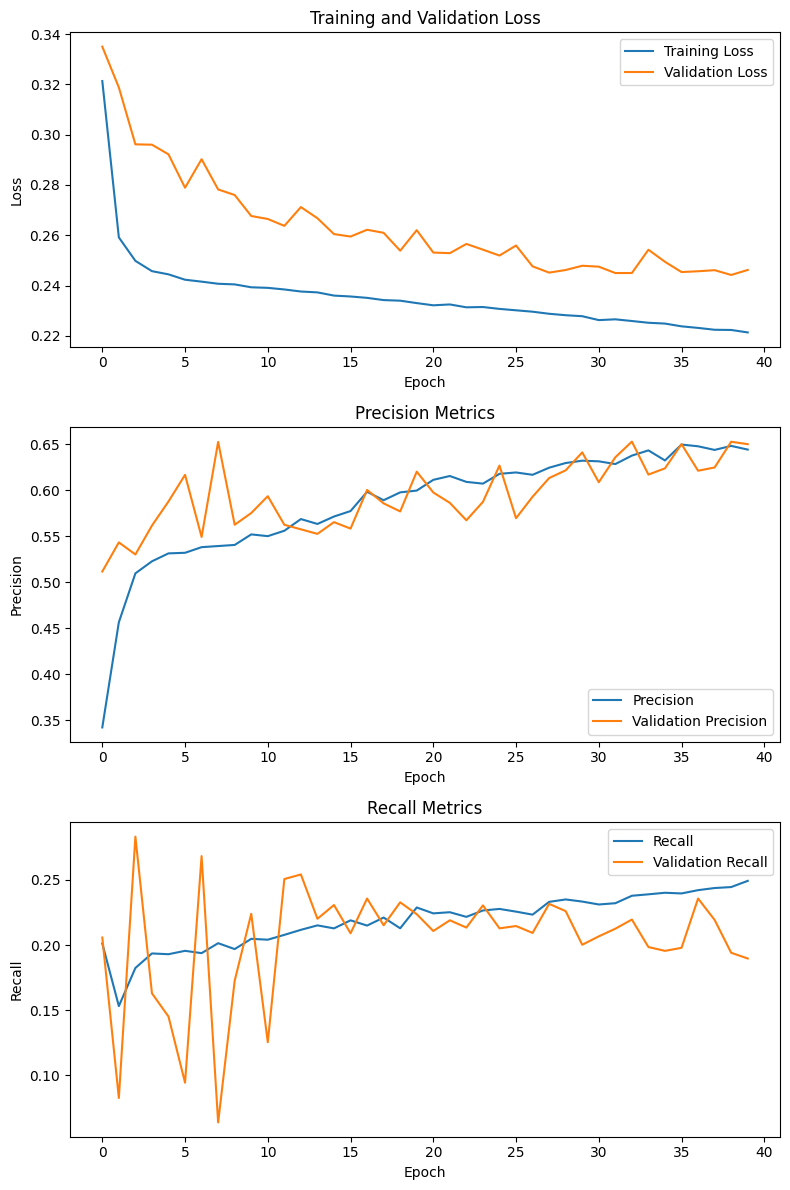

In [ ]:
# CodeGrade Tag Ex4a

# Create a figure and axis object with subplots
fig, ax = plt.subplots(3, figsize=(8, 12))

# Plotting Training and Validation Loss
ax[0].plot(history.history['loss'], label='Training Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plotting Precision Metrics
ax[1].plot(history.history['precision'], label='Precision')
ax[1].plot(history.history['val_precision'], label='Validation Precision')
ax[1].set_title('Precision Metrics')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Precision')
ax[1].legend()

# Plotting Recall Metrics
ax[2].plot(history.history['recall'], label='Recall')
ax[2].plot(history.history['val_recall'], label='Validation Recall')
ax[2].set_title('Recall Metrics')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Recall')
ax[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()

**Load the best weights from your model checkpoint, and create plots demonstrating the classification perfomnce of the model. Be sure to demonstrate the results of the multi-label classification, comparing the top three most probable genres predicted with the ground truth genres for each poster. Include these plots in your report, and critically evaluate on the performance of the model across the classes.**

23/23 [==============================] - 0s 4ms/step


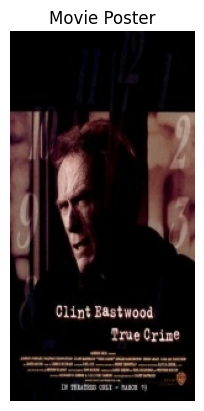

True Genres: ['Crime', 'Drama', 'Mystery']
Predicted Genres: ['Romance', 'Comedy', 'Drama']


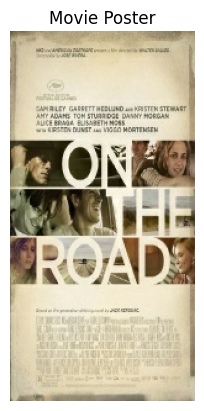

True Genres: ['Adventure', 'Drama']
Predicted Genres: ['Romance', 'Drama', 'Comedy']


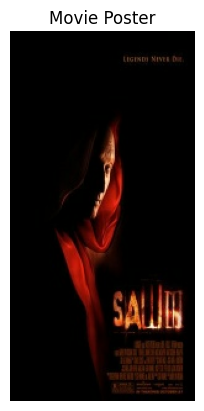

True Genres: ['Horror', 'Mystery']
Predicted Genres: ['Romance', 'Comedy', 'Drama']


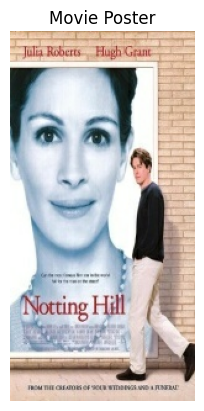

True Genres: ['Comedy', 'Drama', 'Romance']
Predicted Genres: ['Romance', 'Drama', 'Comedy']


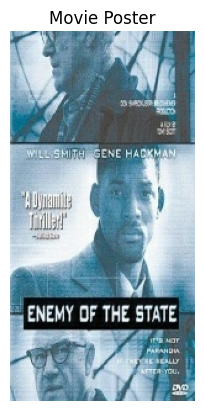

True Genres: ['Action', 'Crime', 'Drama']
Predicted Genres: ['Romance', 'Drama', 'Comedy']


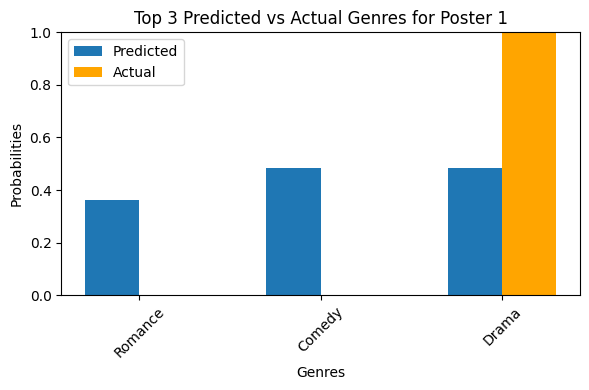

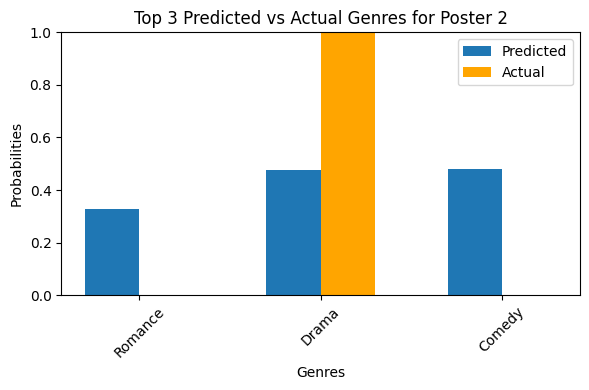

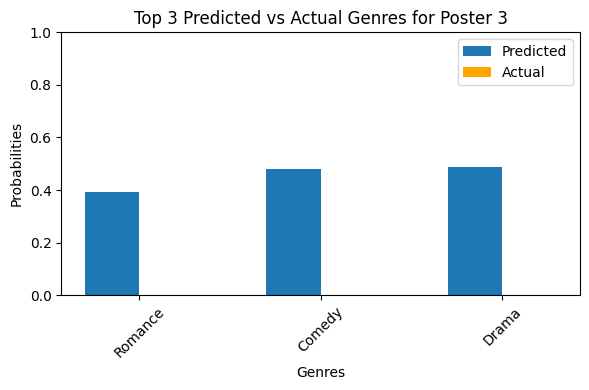

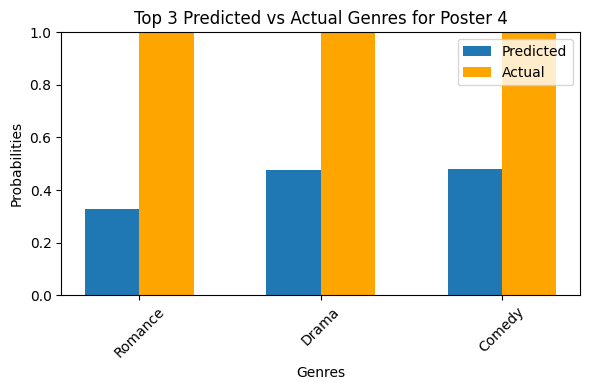

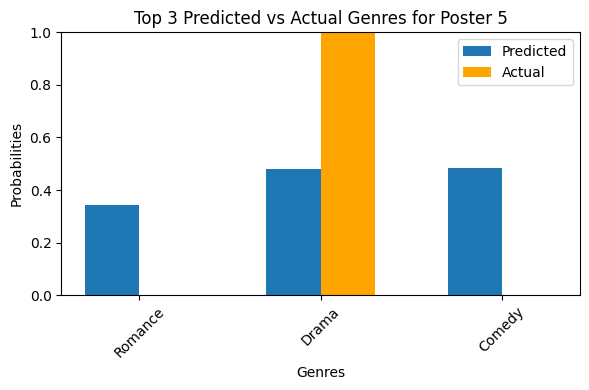

In [ ]:
# CodeGrade Tag Ex4b

# Load the best model weights
model.load_weights(checkpoint_filepath)

# Predict genre probabilities for each poster in the test dataset
predictions = model.predict(test_dataset)

# Prepare other necessary data
true_labels = labels_test
genre_names = genres

# Determine top 3 predicted genres for each poster
top_3_predicted_indices = np.argsort(predictions, axis=1)[:, -3:]

def plot_classification_performance(index, true_labels, genre_names, predictions, top_3_predicted_indices):
    # Display the poster image
    poster = tf.image.decode_jpeg(tf.io.read_file(img_locs_test[0][index]))
    plt.imshow(poster)
    plt.axis('off')
    plt.title('Movie Poster')
    plt.show()

    # Ground truth genres
    true_genre_indices = np.where(true_labels[index] == 1)[0]
    true_genres = [genre_names[i] for i in true_genre_indices]

    # Predicted genres
    predicted_genre_indices = top_3_predicted_indices[index]
    predicted_genres = [genre_names[i] for i in predicted_genre_indices]

    # Print true and predicted genres
    print('True Genres:', true_genres)
    print('Predicted Genres:', predicted_genres)

def plot_genre_comparison(index, true_labels, genre_names, predictions, top_3_predicted_indices):
    # Get the top 3 predictions for the current poster
    top3_pred_indices = top_3_predicted_indices[index]
    top3_pred_values = predictions[index][top3_pred_indices]
    top3_pred_genres = [genre_names[i] for i in top3_pred_indices]

    # Get the ground truth genres for the current poster
    true_genres_indices = np.where(true_labels[index] == 1)[0]
    true_genres = [genre_names[i] for i in true_genres_indices]

    # Create a new plot for each poster
    plt.figure(figsize=(6, 4))
    index = np.arange(len(top3_pred_genres))
    bar_width = 0.3

    # Plot predicted genres
    plt.bar(index, top3_pred_values, bar_width, label='Predicted')

    # Plot ground truth genres
    if true_genres:
        true_values = [1 if genre in true_genres else 0 for genre in top3_pred_genres]
        plt.bar(index + bar_width, true_values, bar_width, label='Actual', color='orange')

    plt.xlabel('Genres')
    plt.ylabel('Probabilities')
    plt.title('Top 3 Predicted vs Actual Genres for Poster {}'.format(i + 1))
    plt.xticks(index + bar_width / 2, top3_pred_genres, rotation=45)
    plt.ylim([0, 1])
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot classification performances for the first 5 posters
num_posters = min(5, len(true_labels))
for i in range(num_posters):
    plot_classification_performance(i, true_labels, genre_names, predictions, top_3_predicted_indices)

# Plot genre comparison for the first 5 posters
for i in range(num_posters):
    plot_genre_comparison(i, true_labels, genre_names, predictions, top_3_predicted_indices)